# Modeling and Simulation in Python

Kyle McCracken

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Earth falling into the sun

Here's a question from the web site [Ask an Astronomer](http://curious.astro.cornell.edu/about-us/39-our-solar-system/the-earth/other-catastrophes/57-how-long-would-it-take-the-earth-to-fall-into-the-sun-intermediate):

"If the Earth suddenly stopped orbiting the Sun, I know eventually it would be pulled in by the Sun's gravity and hit it. How long would it take the Earth to hit the Sun? I imagine it would go slowly at first and then pick up speed."

Here's a solution.

In [2]:
# Here are the units we'll need

s = UNITS.second
year = UNITS.year
J = UNITS.joule
N = UNITS.newton
kg = UNITS.kilogram
m = UNITS.meter;

In [3]:
# And an inition condition (with everything in SI units)

r_0 = 147e9 * m

init = State(x=r_0,
             y=0,
             vx=0 * m / s,
             vy=-30330 * m / s)

,values
x,147000000000.0 meter
y,0
vx,0.0 meter / second
vy,-30330.0 meter / second


In [4]:
# Making a system object

r_earth = 6.371e6 * m
r_sun = 695.508e6 * m

system = System(init=init,
                G=6.674e-11 * N / kg**2 * m**2,
                m1=1.989e30 * kg,
                r_final=r_sun + r_earth,
                m2=5.972e24 * kg,
                t_0=0 * s,
                t_end= 1 * year)

,values
init,x 147000000000.0 meter y ...
G,6.674e-11 meter ** 2 * newton / kilogram ** 2
m1,1.989e+30 kilogram
r_final,701879000.0 meter
m2,5.972e+24 kilogram
t_0,0 second
t_end,1 year


In [5]:
# Here's a function that computes the force of gravity

def universal_gravitation(state, system):
    x, y, vx, vy = state
    e_pos = Vector(x,y)
    e_vel = Vector(vx,vy)
    
    unpack(system)
    
    force = -e_pos.hat() * (G * m1 * m2 / e_pos.mag**2)
    
    return force

In [6]:
universal_gravitation(init, system)

<Quantity([-3.6686486e+22 -0.0000000e+00], 'newton')>

In [7]:
# The slope function

def slope_func(state, t, system):
    x, y, vx, vy = state
    e_pos = Vector(x,y)
    e_vel = Vector(vx,vy)
    
    unpack(system)    
    
    force = universal_gravitation(state, system)
    a = force / m2
    
    return vx, vy, a.x, a.y

In [8]:
# Always test the slope function!

slope_func(init, 0, system)

(<Quantity(0.0, 'meter / second')>,
 <Quantity(-30330.0, 'meter / second')>,
 <Quantity(-0.006143082049146188, 'newton / kilogram')>,
 <Quantity(-0.0, 'newton / kilogram')>)

In [9]:
# Here's an event function that stops the simulation
# before the collision

def event_func(state, t, system):
    unpack(system)
    t = t * s
    return t - t_end

In [10]:
# Always test the event function!

event_func(init, 0, system)

<Quantity(-31556925.9747, 'second')>

In [11]:
# Finally we can run the simulation

results, details = run_ode_solver(system, slope_func, events=event_func)
details

,values
sol,None
t_events,[[31556925.9747]]
nfev,152
njev,0
nlu,0
status,1
message,A termination event occurred.
success,True


In [12]:
# Here's how long it takes...

t_final = get_last_label(results) * s

<Quantity(31556925.9747, 'second')>

In [13]:
# ... expressed in units we understand

t_final.to(UNITS.day)

<Quantity(365.24219878124995, 'day')>

In [15]:
# Before plotting, we run the simulation again with `t_eval`

ts = linspace(t_0, t_final, 201)
results, details = run_ode_solver(system, slope_func, events=event_func, method='RK23', max_step=5000)

In [16]:
# Scaling the time steps to days

results.index /= 60 * 60 * 24
results.head()

,x,y,vx,vy
0.000000e+00,1.470000e+11,0.000000,0.000000e+00,-30330.0
5.396707e-13,1.470000e+11,-0.001414,-2.864369e-10,-30330.0
5.936378e-12,1.470000e+11,-0.015556,-3.150805e-09,-30330.0
5.990345e-11,1.470000e+11,-0.156978,-3.179449e-08,-30330.0
5.995741e-10,1.470000e+11,-1.571191,-3.182313e-07,-30330.0


In [17]:
# Scaling the distance to million km

x = results.x / 1e9;
y = results.y /1e9;

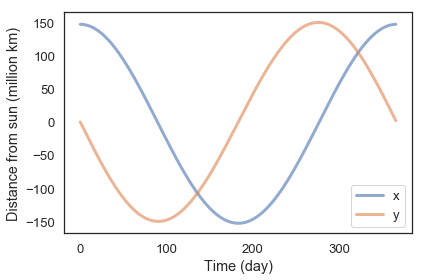

In [18]:
# And plotting

plot(x, label='x')
plot(y, label='y')

decorate(xlabel='Time (day)',
         ylabel='Distance from sun (million km)')

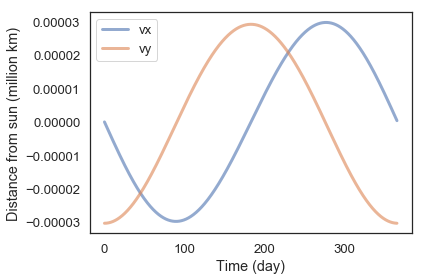

In [19]:
vx = results.vx / 1e9;
vy = results.vy /1e9;

plot(vx, label='vx')
plot(vy, label='vy')

decorate(xlabel='Time (day)',
         ylabel='Distance from sun (million km)')

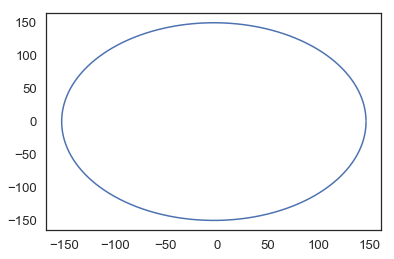

In [20]:
plt.plot(x,y)

In [21]:
def e_g(state, system):
    x, y, vx, vy = state
    e_pos = Vector(x,y)
    e_vel = Vector(vx,vy)
    
    unpack(system)
    
    E_G = -G * m1 * m2 / e_pos.mag
    
    return E_G

In [22]:
def e_k(state, system):
    x, y, vx, vy = state
    e_pos = Vector(x,y)
    e_vel = Vector(vx,vy)
    
    unpack(system)
    
    E_K = 0.5 * G * m1 * m2 / e_pos.mag
    #E_K = 0.5 * m2 * e_vel.mag**2
    
    return E_K

In [23]:
e_k(init, system)

<Quantity(2.696456720816326e+33, 'meter * newton')>

In [24]:
initpos_x = get_first_value(results.x) * m
initpos_y = get_first_value(results.y) * m

initvel_x = get_first_value(results.vx) * m / s
initvel_y = get_first_value(results.vy) * m / s

init_state = State(x=initpos_x, y=initpos_y, vx=initvel_x, vy=initvel_y)

,values
x,147000000000.0 meter
y,0.0 meter
vx,0.0 meter / second
vy,-30330.0 meter / second


In [25]:
finalpos_x = get_last_value(results.x) * m
finalpos_y = get_last_value(results.y) * m

finalvel_x = get_last_value(results.vx) * m / s
finalvel_y = get_last_value(results.vy) * m / s

final_state = State(x=finalpos_x, y=finalpos_y, vx=finalvel_x, vy=finalvel_y)

,values
x,146988535391.49435 meter
y,1852959701.4740303 meter
vx,375.3005897502401 meter / second
vy,-30327.634543364347 meter / second


In [26]:
init_eg = e_g(init_state, system)
final_eg = e_g(final_state, system)
delta_eg = final_eg - init_eg

<Quantity(7.860897476078382e+27, 'meter * newton')>

In [27]:
init_ek = e_k(init_state, system)
final_ek = e_k(final_state, system)
delta_ek = final_ek - init_ek

<Quantity(-3.930448738039191e+27, 'meter * newton')>

In [28]:
init_e = init_eg + init_ek

<Quantity(-2.696456720816326e+33, 'meter * newton')>

In [29]:
final_e = final_eg + final_ek

<Quantity(-2.696452790367588e+33, 'meter * newton')>

In [30]:
delta_e = final_e - init_e

<Quantity(3.930448738039191e+27, 'meter * newton')>